In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as tt

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from networks import Generator

import os
import time
from tqdm.notebook import tqdm, trange
import itertools

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Download dataset files

In [ ]:
#vangogh
!wget -N http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/vangogh2photo.zip -O vangogh2photo.zip

### Custom Dataset

In [4]:
class SingleImageFolder(Dataset):
    def __init__(self, folder, transform, image_size=256):
        self.transform = transform
        self.buffer = []

        init_transform = tt.Compose([
            tt.ToImage(), tt.ToDtype(torch.float32, scale=True),
            tt.Resize(size=image_size, antialias=True)
        ])

        for filename in tqdm(os.listdir(folder)):
            file_path = os.path.join(folder, filename)
            self.buffer.append(init_transform(Image.open(file_path)))

        self.len = len(self.buffer)
        

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.buffer[idx]

In [5]:
normalize_mean = torch.tensor([0.5, 0.5, 0.5])
normalize_std = torch.tensor([0.5, 0.5, 0.5])
img_transform = tt.Normalize(normalize_mean, normalize_std)


def denormalize(images):
    return images*normalize_std[0] + normalize_mean[0]
def to_plt(tensor_img):
    return denormalize(tensor_img.permute(1, 2, 0))

In [6]:
batch_size = 8

photo_dataset = SingleImageFolder('monet2photo/testB/', img_transform)
photo_dataloader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/751 [00:00<?, ?it/s]

In [7]:
import re

def load_checkpoint(path):
    checkpoint = torch.load(path)

    model = Generator()
    model.load_state_dict(checkpoint['gens']['A'])
    model.to(device)

    return model, checkpoint['hist']

def load_checkpoints(folder):
    pattern = re.compile('checkpoint_([a-z_0-9-]*).pth')

    result = {}
    for it in os.listdir(folder):
        match = pattern.match(it)

        if match:
            name = match[1]
            model, hist = load_checkpoint(os.path.join(folder, it))
            result[name] = {
                'model': model,
                'hist': hist   
            }
    
    return result

In [8]:
checkpoints = load_checkpoints('saved_weights')

In [9]:
print([c for c in checkpoints]) 

['vangogh_2e-5_35', 'monet_2e-5_35', 'monet_2e-6_45', 'vangogh_2e-6_45']


In [10]:
torch.save(checkpoints['monet_2e-6_45']['model'].state_dict(), './saved_weights/monet_style.pth')
torch.save(checkpoints['vangogh_2e-6_45']['model'].state_dict(), './saved_weights/vangogh_style.pth')

In [11]:
def running_avg(arr, k_avg=30):
    conv = np.convolve(arr, np.ones(k_avg)/k_avg, mode='valid')

    return conv

def display_history(history, average=150, skip=0):
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].plot(running_avg(history['g'], k_avg=average)[skip:])
    ax[1].plot(running_avg(history['d'], k_avg=average)[skip:])


    fig.suptitle('Averaged combined loss')
    ax[0].set_title("Generators")
    ax[1].set_title("Discriminators")


    for a in ax:
        a.set_xlabel('batch')


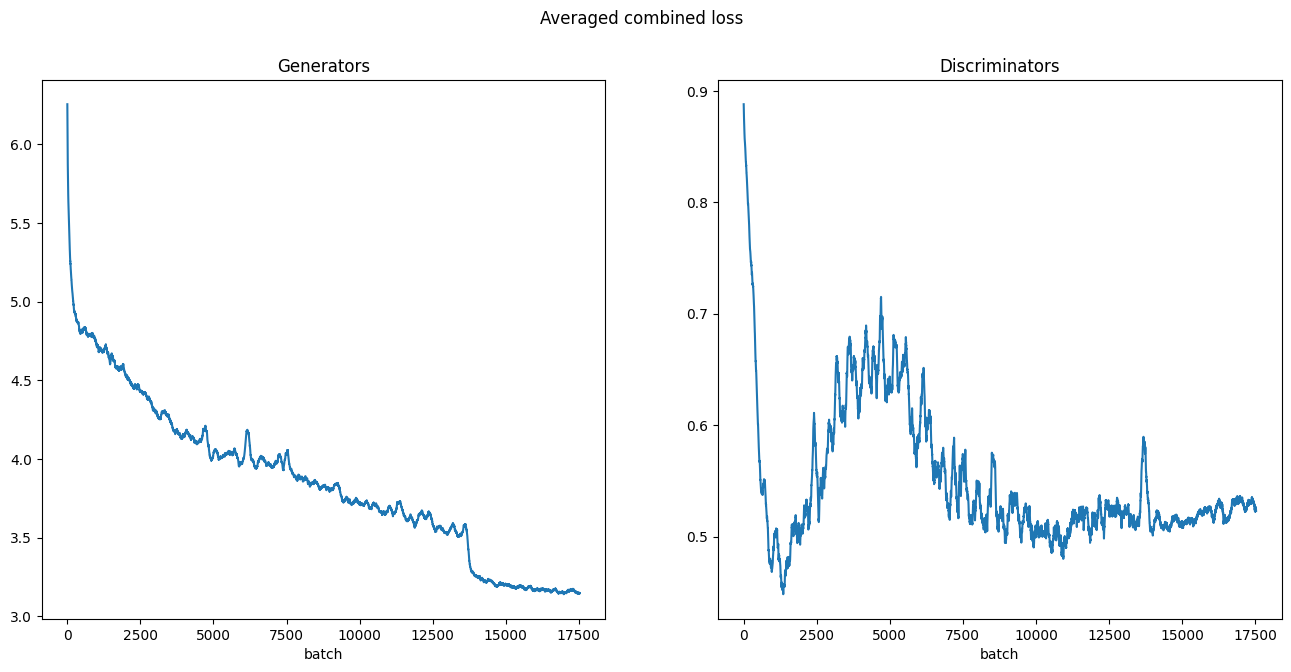

In [12]:
display_history(checkpoints['monet_2e-6_45']['hist'])

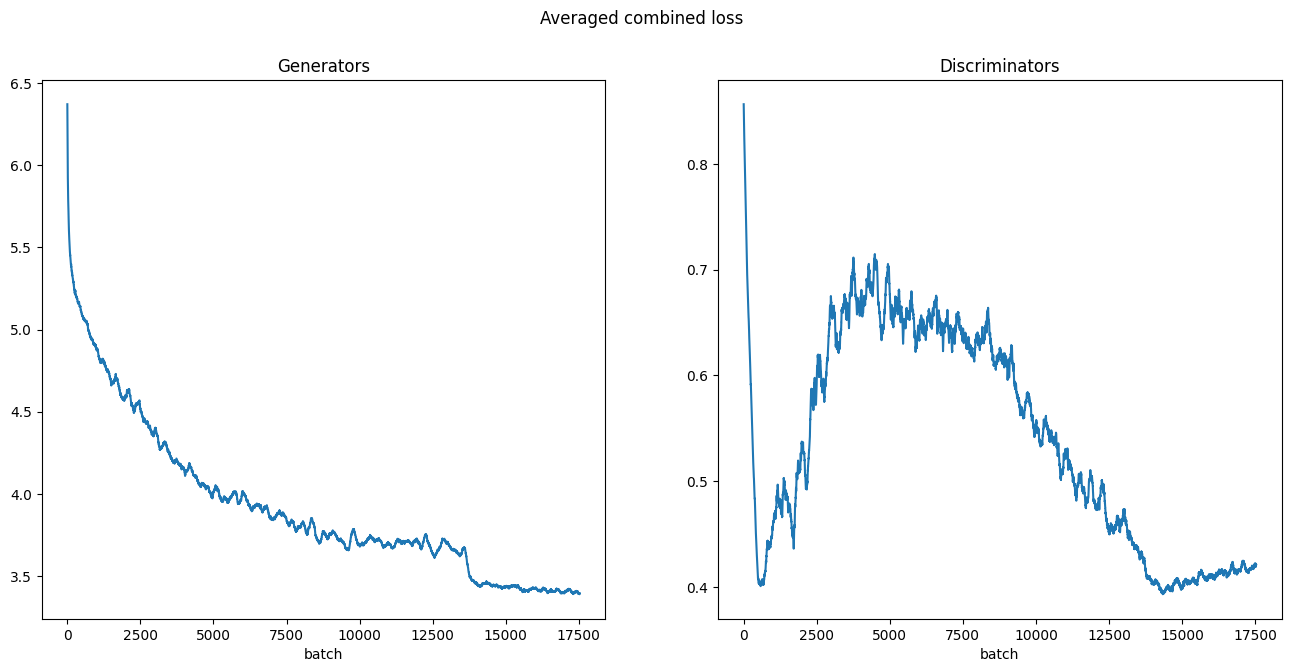

In [13]:
display_history(checkpoints['vangogh_2e-6_45']['hist'])

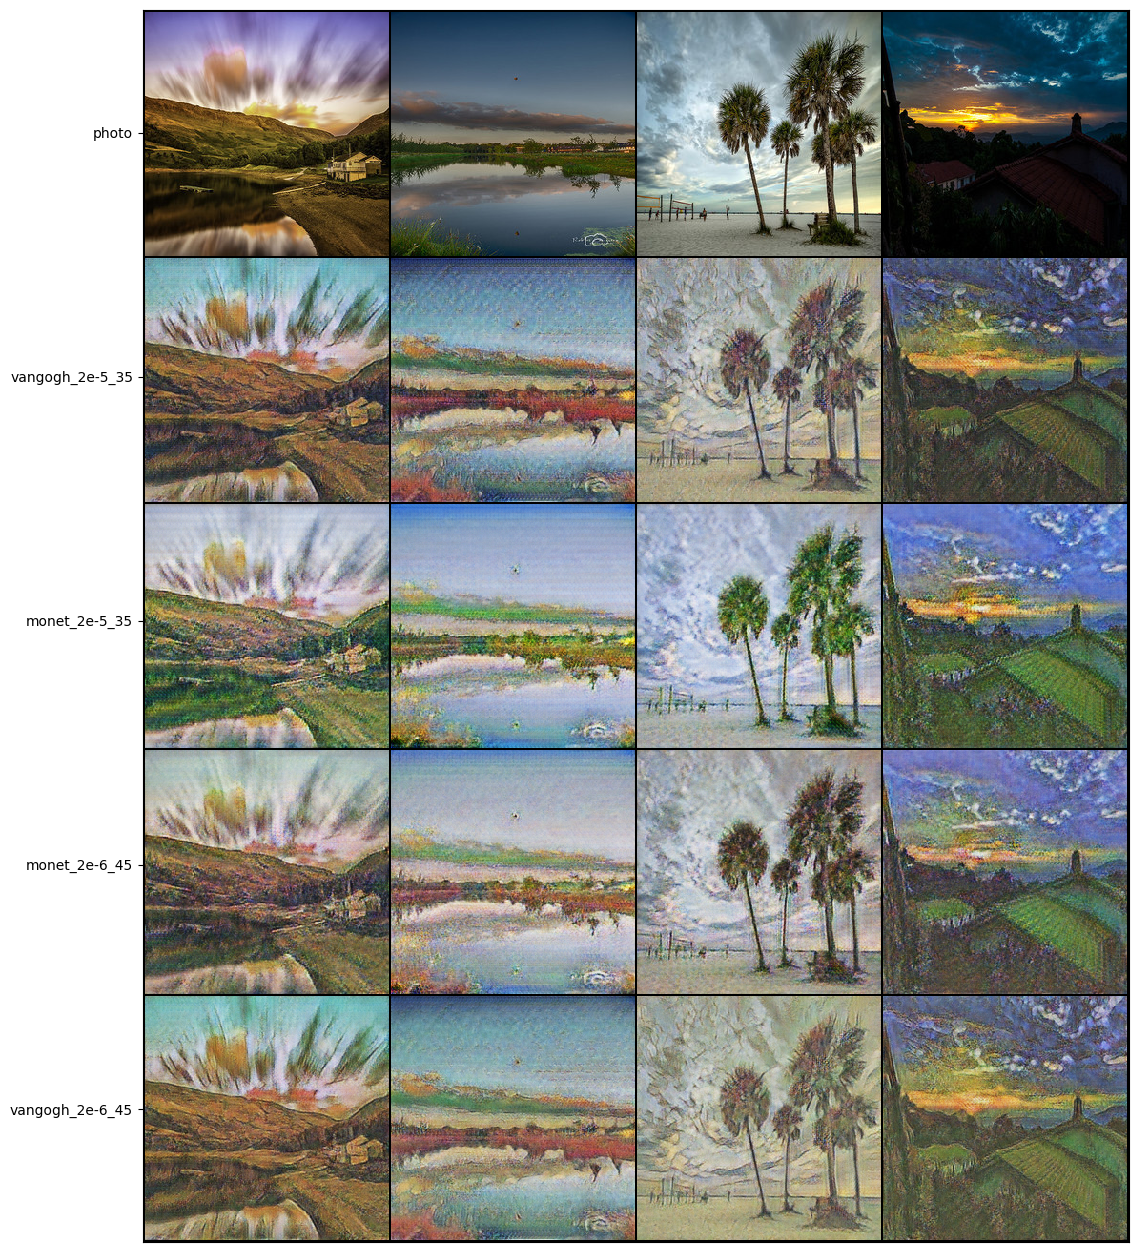

In [14]:
num_in_row = 4

batch = next(iter(photo_dataloader))[:num_in_row]

samples = [batch]
with torch.no_grad():
    for c_d in checkpoints.values():
        samples.append(denormalize(c_d['model'](batch.to(device)).detach()).cpu())
torch_image = make_grid(torch.cat(samples), nrow=num_in_row).permute(1, 2, 0)

fig, ax = plt.subplots(figsize=(16, 16))

labels = ['photo']
labels.extend(checkpoints.keys())
ticks = [128 + 256*i for i in range(len(labels))]

ax.set_yticks(ticks, labels=labels)
ax.set_xticks([])

ax.imshow(torch_image, interpolation='nearest')